# Imports

In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import pickle
import yaml
import matplotlib.pyplot as plt
from collections import Counter
import logging
import torch.nn.functional as F

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.exceptions import ConvergenceWarning
import warnings


import sys
from itertools import product

import time
from datetime import datetime

import pprint




# UTILS

## Simulation run utils


In [2]:


# 0. Simulation run utils



def setup_logging(job_id):
    file_name = f"Output_DS_{job_id}.txt"
    logging.basicConfig(
        filename=file_name,
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
    logger = logging.getLogger(__name__)
    return logger




class FlushFile:
    """File-like wrapper that flushes on every write."""
    def __init__(self, f):
        self.f = f

    def write(self, x):
        self.f.write(x)
        self.f.flush()  # Flush output after write

    def flush(self):
        self.f.flush()



def load_config(file_path='config.yaml'):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)


def extract_unique_treatment_values(df, columns_to_process):
    unique_values = {}

    for key, cols in columns_to_process.items():
        unique_values[key] = {}

        for col in cols:
            all_values = [item for sublist in df[col] for item in sublist]
            unique_values[key][col] = set(all_values)

    log_message = "\nUnique values:\n" + "\n".join(f"{k}: {v}" for k, v in unique_values.items()) + "\n"
    logger.info(log_message)

    return unique_values


def save_simulation_data(global_df, all_losses_dicts, all_epoch_num_lists, results, folder):
    # Check if the folder exists, if not, create it
    if not os.path.exists(folder):
        os.makedirs(folder)

    # Define paths for saving files
    df_path = os.path.join(folder, 'simulation_data.pkl')
    losses_path = os.path.join(folder, 'losses_dicts.pkl')
    epochs_path = os.path.join(folder, 'epoch_num_lists.pkl')
    results_path = os.path.join(folder, 'simulation_results.pkl')

    # Save DataFrame
    # global_df.to_csv(df_path, index=False)
    with open(df_path, 'wb') as f:
        pickle.dump(global_df, f)

    # Save lists and dictionaries with pickle

    with open(losses_path, 'wb') as f:
        pickle.dump(all_losses_dicts, f)
    with open(epochs_path, 'wb') as f:
        pickle.dump(all_epoch_num_lists, f)
    with open(results_path, 'wb') as f:
        pickle.dump(results, f)

    logger.info("Data saved successfully in the folder: %s", folder)


def save_results_to_dataframe(results, folder):
    data = {
        "Configuration": [],
        "Accuracy_A1": [],
        "Accuracy_A2": [],
        "Behavioral Value fn.": [],
        "Method's Value fn.": [],
        "Optimal Value fn.": []
    }

    for config_key, performance in results.items():
        data["Configuration"].append(config_key)
        data["Accuracy_A1"].append(performance.get("Accuracy_A1", None))
        data["Accuracy_A2"].append(performance.get("Accuracy_A2", None))
        data["Behavioral Value fn."].append(performance.get("Behavioral Value fn.", None))
        data["Method's Value fn."].append(performance.get("Method's Value fn.", None))
        data["Optimal Value fn."].append(performance.get("Optimal Value fn.", None))

    df = pd.DataFrame(data)

    # Sort the DataFrame by 'Method's Value fn.' in descending order
    df = df.sort_values(by="Method's Value fn.", ascending=False)

    df.to_csv(f'{folder}/configurations_performance.csv', index=False)
    return df


def load_and_process_data(params, folder):
    # Check if the folder exists, if not, create it
    if not os.path.exists(folder):
        os.makedirs(folder)

    # Define paths to the files
    df_path = os.path.join(folder, 'simulation_data.pkl')
    losses_path = os.path.join(folder, 'losses_dicts.pkl')
    epochs_path = os.path.join(folder, 'epoch_num_lists.pkl')
    results_path = os.path.join(folder, 'simulation_results.pkl')

    # Load DataFrame
    # global_df = pd.read_csv(df_path)
    with open(df_path, 'rb') as f:
        global_df = pickle.load(f)

    # Load lists and dictionaries with pickle
    with open(losses_path, 'rb') as f:
        all_losses_dicts = pickle.load(f)
    with open(epochs_path, 'rb') as f:
        all_epoch_num_lists = pickle.load(f)
    with open(results_path, 'rb') as f:
        results = pickle.load(f)

    # Extract and process unique values
    columns_to_process = {
        'Predicted': ['Predicted_A1', 'Predicted_A2'],
        'Optimal': ['Optimal_A1', 'Optimal_A2']
    }
    # unique_values = extract_unique_treatment_values(global_df, columns_to_process)

    # Process and plot results from all simulations
    for i, losses_dict in enumerate(all_losses_dicts):
        run_name = f"Simulation run trainVval_{i}"
        selected_indices = [i for i in range(params['num_replications'])]
        if  params['f_model'] == 'surr_opt' :
            plot_simulation_surLoss_losses_in_grid(selected_indices, losses_dict, params['n_epoch'], run_name, folder)
        else:
            plot_simulation_Qlearning_losses_in_grid(selected_indices, losses_dict, run_name, folder)

    # Print results for each configuration
    logger.info("\n\n")
    for config_key, performance in results.items():
        logger.info("Configuration: %s\nAverage Performance:\n %s\n", config_key, performance.to_string(index=True, header=False))

    # Call the function to plot value functions
    df = save_results_to_dataframe(results, folder)
    # plot_value_functions(results, folder)




## DGP utils

In [3]:






# 1. DGP utils

def A_sim(matrix_pi, stage):
    N, K = matrix_pi.shape  # sample size and treatment options
    if N <= 1 or K <= 1:
        logger.error("Sample size or treatment options are insufficient! N: %d, K: %d", N, K)
        raise ValueError("Sample size or treatment options are insufficient!")
    if torch.any(matrix_pi < 0):
        logger.error("Treatment probabilities should not be negative!")
        raise ValueError("Treatment probabilities should not be negative!")

    # Normalize probabilities to add up to 1 and simulate treatment A for each row
    pis = matrix_pi.sum(dim=1, keepdim=True)
    probs = matrix_pi / pis
    A = torch.multinomial(probs, 1).squeeze()

    if stage == 1:
        col_names = ['pi_10', 'pi_11', 'pi_12']
    else:
        col_names = ['pi_20', 'pi_21', 'pi_22']

    probs_dict = {name: probs[:, idx] for idx, name in enumerate(col_names)}

    return {'A': A, 'probs': probs_dict}

def transform_Y(Y1, Y2):
    """
    Adjusts Y1 and Y2 values to ensure they are non-negative.
    """
    # Identify the minimum value among Y1 and Y2, only if they are negative
    min_negative_Y = torch.min(torch.cat([Y1, Y2])).item()
    if min_negative_Y < 0:
        Y1_trans = Y1 - min_negative_Y + 1
        Y2_trans = Y2 - min_negative_Y + 1
    else:
        Y1_trans = Y1
        Y2_trans = Y2

    return Y1_trans, Y2_trans



def M_propen(A, Xs, stage):
    """Estimate propensity scores using logistic or multinomial regression."""
    A = np.asarray(A).reshape(-1, 1)
    if A.shape[1] != 1:
        raise ValueError("Cannot handle multiple stages of treatments together!")
    if A.shape[0] != Xs.shape[0]:
        print("A.shape, Xs.shape: ", A.shape, Xs.shape)
        raise ValueError("A and Xs do not match in dimension!")
    if len(np.unique(A)) <= 1:
        raise ValueError("Treatment options are insufficient!")

    # Handle multinomial case using Logistic Regression
    encoder = OneHotEncoder(sparse_output=False)  # Updated parameter name
    A_encoded = encoder.fit_transform(A)
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

    # Suppressing warnings from the solver, if not converged
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        model.fit(Xs, A.ravel())

    # Predicting probabilities
    s_p = model.predict_proba(Xs)

    if stage == 1:
        col_names = ['pi_10', 'pi_11', 'pi_12']
    else:
        col_names = ['pi_20', 'pi_21', 'pi_22']

    #probs_df = pd.DataFrame(s_p, columns=col_names)
    #probs_df = {name: s_p[:, idx] for idx, name in enumerate(col_names)}
    probs_dict = {name: torch.tensor(s_p[:, idx], dtype=torch.float32) for idx, name in enumerate(col_names)}

    return probs_dict





## Neural networks utils

In [4]:



# Neural networks utils


def initialize_nn(params, stage):
    nn = NNClass(
        input_dim=params[f'input_dim_stage{stage}'],
        hidden_dim=params[f'hidden_dim_stage{stage}'],
        output_dim=params[f'output_dim_stage{stage}'],
        num_networks=params['num_networks'],
        dropout_rate=params['dropout_rate'],
        activation_fn_name=params['activation_function'],
        num_hidden_layers=params['num_layers'] - 1  # num_layers is the number of hidden layers
    ).to(params['device'])
    return nn



def batches(N, batch_size, seed=0):
    # Set the seed for PyTorch random number generator for reproducibility
    # torch.manual_seed(seed)

    # Create a tensor of indices from 0 to N-1
    indices = torch.arange(N)

    # Shuffle the indices
    indices = indices[torch.randperm(N)]

    # Yield batches of indices
    for start_idx in range(0, N, batch_size):
        batch_indices = indices[start_idx:start_idx + batch_size]
        yield batch_indices


class NNClass(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_networks, dropout_rate, activation_fn_name, num_hidden_layers):
        super(NNClass, self).__init__()
        self.networks = nn.ModuleList()

        # Map the string name to the actual activation function class
        if activation_fn_name.lower() == 'elu':
            activation_fn = nn.ELU
        elif activation_fn_name.lower() == 'relu':
            activation_fn = nn.ReLU
        else:
            raise ValueError(f"Unsupported activation function: {activation_fn_name}")

        for _ in range(num_networks):
            layers = []
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(activation_fn())
            layers.append(nn.Dropout(dropout_rate))

            for _ in range(num_hidden_layers):  # Adjusting the hidden layers count
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                layers.append(activation_fn())
                layers.append(nn.Dropout(dropout_rate))

            layers.append(nn.Linear(hidden_dim, output_dim))
            layers.append(nn.BatchNorm1d(output_dim))

            network = nn.Sequential(*layers)
            self.networks.append(network)

    def forward(self, x):
        outputs = []
        for network in self.networks:
            outputs.append(network(x))
        return outputs

    def he_initializer(self):
        for network in self.networks:
            for layer in network:
                if isinstance(layer, nn.Linear):
                    nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                    nn.init.constant_(layer.bias, 0)  # Biases can be initialized to zero

    def reset_weights(self):
        for network in self.networks:
            for layer in network:
                if isinstance(layer, nn.Linear):
                    nn.init.constant_(layer.weight, 0.1)
                    nn.init.constant_(layer.bias, 0.0)




# class NNClass(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, num_networks, dropout_rate, activation_fn_name):
#         super(NNClass, self).__init__()
#         self.networks = nn.ModuleList()

#         # Map the string name to the actual activation function class
#         if activation_fn_name.lower() == 'elu':
#             activation_fn = nn.ELU
#         elif activation_fn_name.lower() == 'relu':
#             activation_fn = nn.ReLU
#         else:
#             raise ValueError(f"Unsupported activation function: {activation_fn_name}")

#         for _ in range(num_networks):
#             network = nn.Sequential(
#                 nn.Linear(input_dim, hidden_dim),
#                 activation_fn(),  # Instantiate the activation function
#                 nn.Dropout(dropout_rate),
#                 nn.Linear(hidden_dim, output_dim),
#                 nn.BatchNorm1d(output_dim),
#             )
#             self.networks.append(network)

#     def forward(self, x):
#         outputs = []
#         for network in self.networks:
#             outputs.append(network(x))
#         return outputs

#     def he_initializer(self):
#         for network in self.networks:
#             for layer in network:
#                 if isinstance(layer, nn.Linear):
#                     nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
#                     nn.init.constant_(layer.bias, 0)  # Biases can be initialized to zero

#     def reset_weights(self):
#         for network in self.networks:
#             for layer in network:
#                 if isinstance(layer, nn.Linear):
#                     nn.init.constant_(layer.weight, 0.1)
#                     nn.init.constant_(layer.bias, 0.0)




# class NNClass(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, num_networks, dropout_rate):
#         super(NNClass, self).__init__()
#         self.networks = nn.ModuleList()
#         for _ in range(num_networks):
#             network = nn.Sequential(
#                 nn.Linear(input_dim, hidden_dim),
#                 nn.ELU(alpha=0.4),
#                 nn.Dropout(dropout_rate),
#                 nn.Linear(hidden_dim, output_dim),
#                 nn.BatchNorm1d(output_dim),
#             )
#             self.networks.append(network)

#     def forward(self, x):
#         outputs = []
#         for network in self.networks:
#             outputs.append(network(x))
#         return outputs

#     def he_initializer(self):
#         for network in self.networks:
#             for layer in network:
#                 if isinstance(layer, nn.Linear):
#                     nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
#                     nn.init.constant_(layer.bias, 0)  # Biases can be initialized to zero

#     def reset_weights(self):
#         for network in self.networks:
#             for layer in network:
#                 if isinstance(layer, nn.Linear):
#                     nn.init.constant_(layer.weight, 0.1)
#                     nn.init.constant_(layer.bias, 0.0)




# class NNClass(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, num_networks, dropout_rate):
#         super(NNClass, self).__init__()
#         self.networks = nn.ModuleList()
#         for _ in range(num_networks):
#             network = nn.Sequential(
#                 nn.Linear(input_dim, hidden_dim),
#                 nn.BatchNorm1d(hidden_dim),
#                 nn.ReLU(),
#                 nn.Dropout(dropout_rate),
#                 nn.Linear(hidden_dim, output_dim),
#                 nn.BatchNorm1d(output_dim),
#             )
#             self.networks.append(network)

#     def forward(self, x):
#         outputs = []
#         for network in self.networks:
#             outputs.append(network(x))
#         return outputs

#     def he_initializer(self):
#         for network in self.networks:
#             for layer in network:
#                 if isinstance(layer, nn.Linear):
#                     nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
#                     nn.init.constant_(layer.bias, 0)  # Biases can be initialized to zero

#     def reset_weights(self):
#         for network in self.networks:
#             for layer in network:
#                 if isinstance(layer, nn.Linear):
#                     nn.init.constant_(layer.weight, 0.1)
#                     nn.init.constant_(layer.bias, 0.0)



# class NNClass(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, num_networks, dropout_rate):
#         super(NNClass, self).__init__()
#         self.networks = nn.ModuleList()
#         for _ in range(num_networks):
#             network = nn.Sequential(
#                 nn.Linear(input_dim, hidden_dim),
#                 nn.BatchNorm1d(hidden_dim),
#                 nn.ReLU(),
#                 nn.Linear(hidden_dim, hidden_dim),
#                 nn.Dropout(dropout_rate),
#                 nn.Linear(hidden_dim, hidden_dim),
#                 nn.ReLU(),
#                 nn.Linear(hidden_dim, output_dim),
#                 nn.BatchNorm1d(output_dim),
#             )
#             self.networks.append(network)

#     def forward(self, x):
#         outputs = []
#         for network in self.networks:
#             outputs.append(network(x))
#         return outputs

#     def he_initializer(self):
#         for network in self.networks:
#             for layer in network:
#                 if isinstance(layer, nn.Linear):
#                     nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
#                     nn.init.constant_(layer.bias, 0)  # Biases can be initialized to zero

#     def reset_weights(self):
#         for network in self.networks:
#             for layer in network:
#                 if isinstance(layer, nn.Linear):
#                     nn.init.constant_(layer.weight, 0.1)
#                     nn.init.constant_(layer.bias, 0.0)





## plotting and summary utils


In [5]:




# 2. plotting and summary utils


def plot_v_values(v_dict, num_replications, train_size):

    # Plotting all categories of V values
    plt.figure(figsize=(12, 6))
    for category, values in v_dict.items():
        plt.plot(range(1, num_replications + 1), values, 'o-', label=f'{category} Value function')
    plt.xlabel('Replications (Total: {})'.format(num_replications))
    plt.ylabel('Value function')
    plt.title('Value functions for {} Test Replications (Training Size: {})'.format(num_replications, train_size))
    plt.grid(True)
    plt.legend()
    plt.show()

def abbreviate_config(config):
    abbreviations = {
        "activation_function": "AF",
        "batch_size": "BS",
        "learning_rate": "LR",
        "num_layers": "NL"
    }
    abbreviated_config = {abbreviations[k]: v for k, v in config.items()}
    return str(abbreviated_config)

def plot_value_functions(results, folder):
    data = {
        "Configuration": [],
        "Value Function": []
    }

    for config_key, performance in results.items():
        config_dict = json.loads(config_key)
        abbreviated_config = abbreviate_config(config_dict)
        data["Configuration"].append(abbreviated_config)
        data["Value Function"].append(performance["Method's Value fn."])

    df = pd.DataFrame(data)

    # Sort the DataFrame by 'Value Function' in descending order
    df = df.sort_values(by="Value Function", ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(df["Configuration"], df["Value Function"], color='skyblue')
    plt.xlabel("Value Function")
    plt.title("Value Function of Each Method")
    plt.yticks(rotation=0)  # Rotate configuration labels to vertical
    plt.tight_layout()
    plt.show()
    # plt.savefig(f'{folder}/value_function_plot.png')
    # plt.close()


def plot_epoch_frequency(epoch_num_model_lst, n_epoch, run_name, folder='data'):
    """
    Plots a bar diagram showing the frequency of each epoch number where the model was saved.

    Args:
        epoch_num_model_lst (list of int): List containing the epoch numbers where models were saved.
        n_epoch (int): Total number of epochs for reference in the title.
    """
    # Count the occurrences of each number in the list
    frequency_counts = Counter(epoch_num_model_lst)

    # Separate the keys and values for plotting
    keys = sorted(frequency_counts.keys())
    values = [frequency_counts[key] for key in keys]

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(keys, values, color='skyblue')

    # Add title and labels
    plt.title(f'Bar Diagram of Epoch Numbers: n_epoch={n_epoch}')
    plt.xlabel('Epoch Number')
    plt.ylabel('Frequency')

    # Show the plot
    plt.grid(True)

    plt.show()

    # # Save the plot
    # plot_filename = os.path.join(folder, f"{run_name}.png")
    # plt.savefig(plot_filename)
    # print(f"plot_epoch_frequency Plot saved as: {plot_filename}")
    # plt.close()  # Close the plot to free up memory



def plot_simulation_surLoss_losses_in_grid(selected_indices, losses_dict, n_epoch, run_name, folder, cols=3):
    # Ensure the directory exists
    if not os.path.exists(folder):
        os.makedirs(folder)

    # Calculate the number of rows needed based on the number of selected indices and desired number of columns
    rows = len(selected_indices) // cols + (len(selected_indices) % cols > 0)

    # Create a figure and a set of subplots
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))  # Adjust figure size as needed
    fig.suptitle(f'Training and Validation Loss for Selected Simulations @ n_epoch = {n_epoch}')

    # Flatten the axes array for easy indexing, in case of a single row or column
    axes = axes.flatten()

    for i, idx in enumerate(selected_indices):
        train_loss, val_loss = losses_dict[idx]

        # Plot on the ith subplot
        axes[i].plot(train_loss, label='Training')
        axes[i].plot(val_loss, label='Validation')
        axes[i].set_title(f'Simulation {idx}')
        axes[i].set_xlabel('Epochs')
        axes[i].set_ylabel('Loss')
        axes[i].legend()

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the subtitle
    plt.show()

    # # Save the plot
    # plot_filename = os.path.join(folder, f"{run_name}.png")
    # plt.savefig(plot_filename)
    # print(f"TrainVval Plot saved as: {plot_filename}")
    # plt.close(fig)  # Close the plot to free up memory


def plot_simulation_Qlearning_losses_in_grid(selected_indices, losses_dict, run_name, folder, cols=3):

    all_losses = {
        'train_losses_stage1': {},
        'train_losses_stage2': {},
        'val_losses_stage1': {},
        'val_losses_stage2': {}
    }

    # Iterate over each simulation and extract losses
    for simulation, losses in losses_dict.items():
        train_losses_stage1, train_losses_stage2, val_losses_stage1, val_losses_stage2 = losses

        all_losses['train_losses_stage1'][simulation] = train_losses_stage1
        all_losses['train_losses_stage2'][simulation] = train_losses_stage2
        all_losses['val_losses_stage1'][simulation] = val_losses_stage1
        all_losses['val_losses_stage2'][simulation] = val_losses_stage2


    rows = len(selected_indices) // cols + (len(selected_indices) % cols > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    fig.suptitle('Training and Validation Loss for Selected Simulations')

    axes = axes.flatten()

    for i, idx in enumerate(selected_indices):
        # Check if the replication index exists in the losses for each type
        if idx in all_losses['train_losses_stage1']:
            axes[i].plot(all_losses['train_losses_stage1'][idx], label='Training Stage 1', linestyle='--')
            axes[i].plot(all_losses['val_losses_stage1'][idx], label='Validation Stage 1', linestyle='-.')
            axes[i].plot(all_losses['train_losses_stage2'][idx], label='Training Stage 2', linestyle='--')
            axes[i].plot(all_losses['val_losses_stage2'][idx], label='Validation Stage 2', linestyle='-.')
            axes[i].set_title(f'Simulation {idx}')
            axes[i].set_xlabel('Epochs')
            axes[i].set_ylabel('Loss')
            axes[i].legend()
        else:
            axes[i].set_title(f'Simulation {idx} - Data not available')
            axes[i].axis('off')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


    # # Save the plot
    # plot_filename = os.path.join(folder, f"{run_name}.png")
    # plt.savefig(plot_filename)
    # print(f"TrainVval Plot Deep Q Learning saved as: {plot_filename}")
    # plt.close(fig)  # Close the plot to free up memory





## Loss function and surrogate opt utils


In [6]:

# 3. Loss function and surrogate opt utils

def compute_phi(x, option):
    if option == 1:
        return 1 + torch.tanh(5*x)
    elif option == 2:
        return 1 + 2 * torch.atan(torch.pi * x / 2) / torch.pi
    elif option == 3:
        return 1 + x / torch.sqrt(1 + x ** 2)
    elif option == 4:
        return 1 + x / (1 + torch.abs(x))
    elif option == 5:
        return torch.where(x >= 0, torch.tensor(1.0), torch.tensor(0.0))
    else:
        logger.error("Invalid phi option: %s", option)
        raise ValueError("Invalid phi option")


def gamma_function_old_vec(a, b, A, option):
    a = a.to(device)
    b = b.to(device)

    phi_a = compute_phi(a, option)
    phi_b = compute_phi(b, option)
    phi_b_minus_a = compute_phi(b - a, option)
    phi_a_minus_b = compute_phi(a - b, option)
    phi_neg_a = compute_phi(-a, option)
    phi_neg_b = compute_phi(-b, option)

    gamma = torch.where(A == 1, phi_a * phi_b,
                        torch.where(A == 2, phi_b_minus_a * phi_neg_a,
                                    torch.where(A == 3, phi_a_minus_b * phi_neg_b,
                                                torch.tensor(0.0).to(device))))
    return gamma


def compute_gamma(a, b, option):
    # Assume a and b are already tensors, check if they need to be sent to a specific device and ensure they have gradients if required
    a = a.detach().requires_grad_(True)
    b = b.detach().requires_grad_(True)

    # asymmetric
    if option == 1:
        result = ((torch.exp(a + b) - 1) / ((1 + torch.exp(a)) * (1 + torch.exp(b))) ) +  ( 1 / (1 + torch.exp(a) + torch.exp(b)))
    # symmetric
    elif option == 2:
        result = (torch.exp(a + b) * ((a * (torch.exp(b) - 1))**2 + (torch.exp(a) - 1) * (-torch.exp(a) + (torch.exp(b) - 1) * (torch.exp(a) - torch.exp(b) + b)))) / ((torch.exp(a) - 1)**2 * (torch.exp(b) - 1)**2 * (torch.exp(a) - torch.exp(b)))
    else:
        result = None
    return result


def gamma_function_new_vec(a, b, A, option):
    # a, b, and A are torch tensors and move them to the specified device
    a = torch.tensor(a, dtype=torch.float32, requires_grad=True).to(device)
    b = torch.tensor(b, dtype=torch.float32, requires_grad=True).to(device)

    # a = torch.tensor(a, dtype=torch.float32).to(device)
    # b = torch.tensor(b, dtype=torch.float32).to(device)
    A = torch.tensor(A, dtype=torch.int32).to(device)

    # Apply compute_gamma_vectorized across the entire tensors based on A
    result_1 = compute_gamma(a, b, option)
    result_2 = compute_gamma(b - a, -a, option)
    result_3 = compute_gamma(a - b, -b, option)

    gamma = torch.where(A == 1, result_1,
                        torch.where(A == 2, result_2,
                                    torch.where(A == 3, result_3,
                                                torch.tensor(0.0).to(device) )))

    return gamma


def main_loss_gamma(stage1_outputs, stage2_outputs, A1, A2, Ci, option, surrogate_num):

    if surrogate_num == 1:
        # # surrogate 1
        gamma_stage1 = gamma_function_old_vec(stage1_outputs[:, 0], stage1_outputs[:, 1], A1.int(), option)
        gamma_stage2 = gamma_function_old_vec(stage2_outputs[:, 0], stage2_outputs[:, 1], A2.int(), option)
    else:
        # surrogate 2 - contains symmetric and non symmetic cases
        gamma_stage1 = gamma_function_new_vec(stage1_outputs[:, 0], stage1_outputs[:, 1], A1.int(), option)
        gamma_stage2 = gamma_function_new_vec(stage2_outputs[:, 0], stage2_outputs[:, 1], A2.int(), option)

    loss = -torch.mean(Ci * gamma_stage1 * gamma_stage2)

    return loss




def process_batches(model1, model2, data, params, optimizer, is_train=True):
    batch_size = params['batch_size']
    total_loss = 0
    num_batches = (data['input1'].shape[0] + batch_size - 1) // batch_size

    if is_train:
        model1.train()
        model2.train()
    else:
        model1.eval()
        model2.eval()

    for batch_idx in batches(data['input1'].shape[0], batch_size):
        batch_data = {k: v[batch_idx].to(params['device']) for k, v in data.items()}

        with torch.set_grad_enabled(is_train):
            outputs_stage1 = model1(batch_data['input1'])
            outputs_stage2 = model2(batch_data['input2'])

            outputs_stage1 = torch.stack(outputs_stage1, dim=1).squeeze()
            outputs_stage2 = torch.stack(outputs_stage2, dim=1).squeeze()

            loss = main_loss_gamma(outputs_stage1, outputs_stage2, batch_data['A1'], batch_data['A2'],
                                   batch_data['Ci'], option=params['option_sur'], surrogate_num=params['surrogate_num'])
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / num_batches
    return avg_loss


def initialize_and_prepare_model(stage, params, sample_size):
    model = initialize_nn(params, stage).to(params['device'])

    # Check for the initializer type in params and apply accordingly
    if params['initializer'] == 'he':
        model.he_initializer()  # He initialization (aka Kaiming initialization)
    else:
        model.reset_weights()  # Custom reset weights to a specific constant eg. 0.1

    return model




def initialize_optimizer_and_scheduler(nn_stage1, nn_stage2, params):
    # Combine parameters from both models
    combined_params = list(nn_stage1.parameters()) + list(nn_stage2.parameters())

    # Select optimizer based on params
    if params['optimizer_type'] == 'adam':
        optimizer = optim.Adam(combined_params, lr=params['optimizer_lr'])
    elif params['optimizer_type'] == 'rmsprop':
        optimizer = optim.RMSprop(combined_params, lr=params['optimizer_lr'], weight_decay=params['optimizer_weight_decay'])
    else:
        logging.warning("No valid optimizer type found in params['optimizer_type'], defaulting to Adam.")
        optimizer = optim.Adam(combined_params, lr=params['optimizer_lr'])  # Default to Adam if none specified

    # Initialize scheduler only if use_scheduler is True
    scheduler = None
    if params.get('use_scheduler', False):  # Defaults to False if 'use_scheduler' is not in params
        if params['scheduler_type'] == 'reducelronplateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=10)
        elif params['scheduler_type'] == 'steplr':
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=params['scheduler_step_size'], gamma=params['scheduler_gamma'])
        elif params['scheduler_type'] == 'cosineannealing':
            T_max = (params['sample_size'] // params['batch_size']) * params['n_epoch']
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=0.0001)
        else:
            logging.warning("No valid scheduler type found in params['scheduler_type'], defaulting to StepLR.")
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=params['scheduler_step_size'], gamma=params['scheduler_gamma'])  # Default to StepLR if none specified

    return optimizer, scheduler


def update_scheduler(scheduler, params, val_loss=None):

    if scheduler is None:
        logging.warning("Scheduler is not initialized but update_scheduler was called.")
        return

    # Check the type of scheduler and step accordingly
    if params['scheduler_type'] == 'reducelronplateau':
        # ReduceLROnPlateau expects a metric, usually the validation loss, to step
        if val_loss is not None:
            scheduler.step(val_loss)
        else:
            logging.warning("Validation loss required for ReduceLROnPlateau but not provided.")
    else:
        # Other schedulers like StepLR or CosineAnnealingLR do not use the validation loss
        scheduler.step()








## Q learning utils

In [7]:







# 3. Q learning utils

def train_and_validate(model, optimizer, scheduler, train_inputs, train_actions, train_targets, val_inputs, val_actions, val_targets, params, stage_number):

    batch_size, device, n_epoch, sample_size = params['batch_size'], params['device'], params['n_epoch'], params['sample_size']
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_params = None
    epoch_num_model = 0

    for epoch in range(n_epoch):
        model.train()
        total_train_loss = 0

        for batch_idx in batches(train_inputs.shape[0], batch_size, epoch):
            batch_idx = batch_idx.to(device)
            inputs_batch = torch.index_select(train_inputs, 0, batch_idx).to(device)
            actions_batch = torch.index_select(train_actions, 0, batch_idx).to(device)
            targets_batch = torch.index_select(train_targets, 0, batch_idx).to(device)
            combined_inputs = torch.cat((inputs_batch, actions_batch.unsqueeze(-1)), dim=1)

            optimizer.zero_grad()
            outputs = model(combined_inputs)
            loss = F.mse_loss(torch.cat(outputs, dim=0).view(-1), targets_batch)
            total_train_loss += loss.item()
            loss.backward(retain_graph=True)
            optimizer.step()

        num_batches_t = (train_inputs.shape[0] + batch_size - 1) // batch_size
        avg_train_loss = total_train_loss / num_batches_t

        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch_idx in batches(val_inputs.shape[0], batch_size):
                batch_idx = batch_idx.to(device)
                inputs_batch = torch.index_select(val_inputs, 0, batch_idx).to(device)
                actions_batch = torch.index_select(val_actions, 0, batch_idx).to(device)
                targets_batch = torch.index_select(val_targets, 0, batch_idx).to(device)
                combined_inputs = torch.cat((inputs_batch, actions_batch.unsqueeze(-1)), dim=1)

                outputs = model(combined_inputs)
                loss = F.mse_loss(torch.cat(outputs, dim=0).view(-1), targets_batch)

                total_val_loss += loss.item()

        num_batches_v = (val_inputs.shape[0] + batch_size - 1) // batch_size
        avg_val_loss = total_val_loss / num_batches_v
        val_losses.append(avg_val_loss)

        if avg_val_loss < best_val_loss and epoch > 20:
            epoch_num_model = epoch
            best_val_loss = avg_val_loss
            best_model_params = model.state_dict()

        # scheduler.step()

    # Define file paths for saving models
    model_dir = f"models/{params['job_id']}"
    # Check if the directory exists, if not, create it
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Save the best model parameters after all epochs
    if best_model_params is not None:
        model_path = os.path.join(model_dir, f'best_model_stage_Q_{stage_number}_{sample_size}.pt')
        torch.save(best_model_params, model_path)

    return train_losses, val_losses, epoch_num_model


def initialize_model_and_optimizer(params, stage):
    nn = initialize_nn(params, stage).to(device)
    optimizer = optim.Adam(nn.parameters(), lr=params['optimizer_lr'])
    # optimizer = optim.Adam(nn.parameters(), lr=params['optimizer_lr'], betas=params['optimizer_betas'], eps=params['optimizer_eps'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=params['scheduler_step_size'], gamma=params['scheduler_gamma'])
    return nn, optimizer, scheduler

def evaluate_model_on_actions(model, inputs, action_t):
    actions_list = [1, 2, 3]
    outputs_list = []
    for action_value in actions_list:
        action_tensor = torch.full_like(action_t, action_value).unsqueeze(-1)
        combined_inputs = torch.cat((inputs, action_tensor), dim=1).to(device)
        with torch.no_grad():
            outputs = model(combined_inputs)
        outputs_list.append(outputs[0])

    max_outputs, _ = torch.max(torch.cat(outputs_list, dim=1), dim=1)
    return max_outputs






## Eval fn utils


In [8]:


# 5. Eval fn utils

def compute_test_outputs(nn, test_input, A_tensor, params, is_stage1=True):
    with torch.no_grad():
        if params['f_model'] == "surr_opt":
            # Perform the forward pass
            test_outputs_i = nn(test_input)

            # Directly stack the required outputs and perform computations in a single step
            test_outputs = torch.stack(test_outputs_i[:2], dim=1).squeeze()

            # Compute treatment assignments directly without intermediate variables
            test_outputs = torch.stack([
                torch.zeros_like(test_outputs[:, 0]),
                -test_outputs[:, 0],
                -test_outputs[:, 1]
            ], dim=1)
        else:
            # Modify input for each action and perform a forward pass
            input_tests = [
                torch.cat((test_input, torch.full_like(A_tensor, i).unsqueeze(-1)), dim=1).to(params['device'])
                for i in range(1, 4)  # Assuming there are 3 actions
            ]

            # Forward pass for each modified input and stack the results
            test_outputs = torch.stack([
                nn(input_stage)[0] for input_stage in input_tests
            ], dim=1)

    # Determine the optimal action based on the computed outputs
    optimal_actions = torch.argmax(test_outputs, dim=1) + 1
    return optimal_actions.squeeze().to(params['device']), test_outputs

def prepare_stage2_test_input(O1_tensor_test, A1, g1_opt_conditions, Z1_tensor_test):

    # g1_opt_conditions gives the optimal action, we use it to compute Y1_pred
    Y1_pred = torch.exp(1.5 - torch.abs(1.5 * O1_tensor_test[:, 0] + 2) * (A1 - g1_opt_conditions)**2) + Z1_tensor_test

    # Form the test input for stage 2 by concatenating the necessary tensors
    test_input_stage2 = torch.cat([O1_tensor_test, A1.unsqueeze(1), Y1_pred.unsqueeze(1)], dim=1)

    # # DEBUG PRINT
    # Y1_stats = [torch.min(Y1_pred), torch.max(Y1_pred), torch.mean(Y1_pred)]
    # stats_message = f"Y1_pred [min, max, mean]: {Y1_stats}"
    # tqdm.write(stats_message)

    return test_input_stage2, Y1_pred



def prepare_Y2_pred(O1_tensor_test, A1, A2, g2_opt_conditions, Z1_tensor_test, Z2_tensor_test):

    # g2_opt_conditions gives the optimal action, we use it to compute Y2_pred
    Y2_pred = torch.exp(1.26 - torch.abs(1.5 * O1_tensor_test[:, 2] - 2) * (A2 - g2_opt_conditions)**2) + Z2_tensor_test

    # # DEBUG PRINT
    # stats_message = f"Y2_pred [min, max, mean]: [{torch.min(Y2_pred)}, {torch.max(Y2_pred)}, {torch.mean(Y2_pred)}]"
    # tqdm.write(stats_message)

    return Y2_pred



def calculate_policy_values(Y1_tensor, Y2_tensor, d1_star, d2_star, Y1_pred, Y2_pred, V_replications, Z1_tensor_test, Z2_tensor_test):
    # Rewards using Optimal policy
    Y1_test_opt = torch.exp(torch.tensor(1.5)) + Z1_tensor_test
    Y2_test_opt = torch.exp(torch.tensor(1.26)) + Z2_tensor_test

    # DEBUG PRINT
    message = f'\nY1_opt mean: {torch.mean(Y1_test_opt)}, Y2_opt mean: {torch.mean(Y2_test_opt)}, Y1_opt+Y2_opt mean: {torch.mean(Y1_test_opt + Y2_test_opt)} \n\n'
    print(message)

    V_d1_d2_opt = torch.mean(Y1_test_opt + Y2_test_opt).cpu().item()  # Calculate the mean value and convert to Python scalar
    V_replications["V_replications_M1_optimal"].append(V_d1_d2_opt)  # Append to the list for optimal policy values

    # Value function using Behavioral policy
    V_d1_d2 = torch.mean(Y1_tensor + Y2_tensor).cpu().item()  # Calculate the mean value and convert to Python scalar
    V_replications["V_replications_M1_behavioral"].append(V_d1_d2)  # Append to the list for behavioral policy values

    # Value function using Current method's policy
    V_replications["V_replications_M1_pred"].append(torch.mean(Y1_pred + Y2_pred).item())  # Append the mean value as a Python scalar to the list for current approach values

    return V_replications



def initialize_and_load_model(stage, sample_size, params):
    # Initialize the neural network model
    nn_model = initialize_nn(params, stage).to(params['device'])

    # Define the directory and file name for the model
    model_dir = f"models/{params['job_id']}"
    if params['f_model']=="surr_opt":
        model_filename = f'best_model_stage_surr_{stage}_{sample_size}.pt'
    else:
        model_filename = f'best_model_stage_Q_{stage}_{sample_size}.pt'

    model_path = os.path.join(model_dir, model_filename)

    # Set up logging
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)

    # Check if the model file exists before attempting to load
    if not os.path.exists(model_path):
        logger.error(f"No model file found at {model_path}. Please check the file path and model directory.")
        return None  # or handle the error as needed

    # Load the model's state dictionary from the file
    nn_model.load_state_dict(torch.load(model_path, map_location=params['device']))

    # Set the model to evaluation mode
    nn_model.eval()

    return nn_model





# Value function Estimator

In [9]:



def train_and_validate_W_estimator(model, optimizer, scheduler, train_inputs, train_actions, train_targets, val_inputs, val_actions, val_targets, batch_size, device, n_epoch, stage_number, sample_size, params):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_params = None
    epoch_num_model = 0

    for epoch in range(n_epoch):
        model.train()
        total_train_loss = 0

        for batch_idx in batches(train_inputs.shape[0], batch_size, epoch):
            batch_idx = batch_idx.to(device)
            inputs_batch = torch.index_select(train_inputs, 0, batch_idx).to(device)
            actions_batch = torch.index_select(train_actions, 0, batch_idx).to(device)
            targets_batch = torch.index_select(train_targets, 0, batch_idx).to(device)
            combined_inputs = torch.cat((inputs_batch, actions_batch.unsqueeze(-1)), dim=1)

            optimizer.zero_grad()
            outputs = model(combined_inputs)


            loss = F.mse_loss(torch.cat(outputs, dim=0).view(-1), targets_batch)

            total_train_loss += loss.item()
            loss.backward(retain_graph=True)
            optimizer.step()


        num_batches_t = (train_inputs.shape[0] + batch_size - 1) // batch_size
        avg_train_loss = total_train_loss / num_batches_t

        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch_idx in batches(val_inputs.shape[0], batch_size):
                batch_idx = batch_idx.to(device)
                inputs_batch = torch.index_select(val_inputs, 0, batch_idx).to(device)
                actions_batch = torch.index_select(val_actions, 0, batch_idx).to(device)
                targets_batch = torch.index_select(val_targets, 0, batch_idx).to(device)
                combined_inputs = torch.cat((inputs_batch, actions_batch.unsqueeze(-1)), dim=1)


                outputs = model(combined_inputs)



                loss = F.mse_loss(torch.cat(outputs, dim=0).view(-1), targets_batch)

                total_val_loss += loss.item()

        num_batches_v = (val_inputs.shape[0] + batch_size - 1) // batch_size
        avg_val_loss = total_val_loss / num_batches_v
        val_losses.append(avg_val_loss)

        if avg_val_loss < best_val_loss and epoch > 20:
            epoch_num_model = epoch
            best_val_loss = avg_val_loss
            best_model_params = model.state_dict()

        #scheduler.step()

    # Define file paths for saving models
    model_dir = f"models/{params['job_id']}"
    # Check if the directory exists, if not, create it
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Save the best model parameters after all epochs
    if best_model_params is not None:
        model_path = os.path.join(model_dir, f"best_model_stage_Q_{stage_number}_{sample_size}_W_estimator_{params['f_model']}.pt")
        torch.save(best_model_params, model_path)


    return train_losses, val_losses, epoch_num_model



def valFn_estimate(Qhat1_H1d1, Qhat2_H2d2, Qhat1_H1A1, Qhat2_H2A2, A1_tensor, A2_tensor, A1, A2, Y1_tensor, Y2_tensor , P_A1_given_H1_tensor, P_A2_given_H2_tensor):

    # # IPW estimator
    # indicator1 = ((A1_tensor == A1)/P_A1_given_H1_tensor)
    # indicator2 = ((A2_tensor == A2)/P_A2_given_H2_tensor)
    # term = (Y1_tensor + Y2_tensor) * indicator1 * indicator2
    # return torch.mean(term).item()

    # # term I got
    # term_1 = (Y1_tensor - Qhat1_H1A1.squeeze(1)) *((A1_tensor == A1)/P_A1_given_H1_tensor)
    # term_2 = (Y2_tensor - Qhat2_H2A2.squeeze(1) ) * ((A2_tensor == A2)/P_A2_given_H2_tensor)
    # return torch.mean(Qhat1_H1d1.squeeze(1)  + term_1 + term_2 + Qhat2_H2d2.squeeze(1)).item()

    # # 1st term on board (incorrect)
    # term_1 = (Y1_tensor - Qhat1_H1A1.squeeze(1) + Qhat2_H2d2.squeeze(1) ) *((A1_tensor == A1)/P_A1_given_H1_tensor)
    # term_2 = (Y2_tensor- Qhat2_H2A2.squeeze(1) ) * ((A2_tensor == A2)/P_A2_given_H2_tensor)
    # return torch.mean(Qhat1_H1d1.squeeze(1)  + term_1 + term_2).item()

    # corrected term in email
    indicator1 = ((A1_tensor == A1)/P_A1_given_H1_tensor)
    indicator2 = ((A2_tensor == A2)/P_A2_given_H2_tensor)
    term_1 = (Y1_tensor - Qhat1_H1A1.squeeze(1) + Qhat2_H2d2.squeeze(1) ) * indicator1
    term_2 = (Y2_tensor - Qhat2_H2A2.squeeze(1) ) * indicator1 * indicator2
    return torch.mean(Qhat1_H1d1.squeeze(1) ).item() + torch.mean(term_1 + term_2).item()




def initialize_and_train_stage(stage, input_tensor, action_tensor, outcome_tensor, val_input_tensor, val_action_tensor, val_outcome_tensor, params):

    sample_size = params['sample_size']

    """Initialize, train and validate a model for a given stage."""
    model, optimizer, scheduler = initialize_model_and_optimizer(params, stage)
    losses, val_losses, epoch_num = train_and_validate_W_estimator(
        model, optimizer, scheduler, input_tensor, action_tensor, outcome_tensor, val_input_tensor, val_action_tensor, val_outcome_tensor,
        params['batch_size'], params['device'], params['n_epoch'], stage, sample_size, params
    )

    # Define the directory and file name for the model
    model_dir = f"models/{params['job_id']}"
    model_filename = f"best_model_stage_Q_{stage}_{params['sample_size']}_W_estimator_{params['f_model']}.pt"

    model_path = os.path.join(model_dir, model_filename)

    # Check if the model file exists before attempting to load
    if not os.path.exists(model_path):
        logger.error(f"No model file found at {model_path}. Please check the file path and model directory.")
        return None  # or handle the error as needed

    # Load the model's state dictionary from the file
    model.load_state_dict(torch.load(model_path, map_location=params['device']))

    model.eval()


    return model



def calculate_policy_values_W_estimator(train_tens, params, A1, A2, P_A1_given_H1_tensor, P_A2_given_H2_tensor):


    train_size = int(params['training_validation_prop'] * params['sample_size'])
    train_test_tensors = [tensor[:train_size] for tensor in train_tens ]
    val_test_tensors = [tensor[train_size:] for tensor in train_tens]

    test_input_stage1, test_input_stage2,  train_Y1, train_Y2, train_A1, train_A2 = train_test_tensors
    val_input_stage1, val_input_stage2, val_Y1, val_Y2, val_A1, val_A2 = val_test_tensors


    A1_tr, A2_tr = [tensor[:train_size] for tensor in [A1, A2] ] # actions from chosen policy
    A1_val, A2_val = [tensor[train_size:] for tensor in [A1, A2]] # actions from chosen policy



    # Duplicate the params dictionary
    param_W = params.copy()

    # Update specific values in param_W
    param_W.update({
          'num_networks': 1,
          'input_dim_stage1': 6,
          'output_dim_stage1': 1,
          'input_dim_stage2': 8,
          'output_dim_stage2': 1,
      })




    nn_stage2, optimizer_2, scheduler_2 = initialize_model_and_optimizer(param_W, 2)
    train_losses_stage2, val_losses_stage2, epoch_num_model_2 = train_and_validate_W_estimator(nn_stage2, optimizer_2, scheduler_2, test_input_stage2, train_A2, train_Y2, val_input_stage2, val_A2, val_Y2, params['batch_size'], device, params['n_epoch'], 2, params['sample_size'], params)


    model_dir = f"models/{params['job_id']}"
    model_filename = f"best_model_stage_Q_{2}_{params['sample_size']}_W_estimator_{params['f_model']}.pt"
    model_path = os.path.join(model_dir, model_filename)
    nn_stage2.load_state_dict(torch.load(model_path, map_location=params['device']))

    nn_stage2.eval()

    combined_inputs2 = torch.cat((test_input_stage2, A2_tr.unsqueeze(-1)), dim=1)
    test_tr_outputs_stage2 = nn_stage2(combined_inputs2)[0]  #compute_test_outputs(nn_stage2, test_input_stage2, A2_tr, device, params, is_stage1=False)

    train_Y1_hat = test_tr_outputs_stage2.squeeze(1) + train_Y1 # pseudo outcome


    combined_inputs2val = torch.cat((val_input_stage2, A2_val.unsqueeze(-1)), dim=1)
    test_val_outputs_stage2 = nn_stage2(combined_inputs2val)[0]  #compute_test_outputs(nn_stage2, val_input_stage2, A2_val, device, params, is_stage1=False)
    val_Y1_hat = test_val_outputs_stage2.squeeze() + val_Y1 # pseudo outcome




    nn_stage1, optimizer_1, scheduler_1 = initialize_model_and_optimizer(param_W, 1)
    train_losses_stage1, val_losses_stage1, epoch_num_model_1 = train_and_validate_W_estimator(nn_stage1, optimizer_1, scheduler_1, test_input_stage1, train_A1, train_Y1_hat, val_input_stage1, val_A1, val_Y1_hat, params['batch_size'], device, params['n_epoch'], 1, params['sample_size'], params)



    model_dir = f"models/{params['job_id']}"
    model_filename = f"best_model_stage_Q_{1}_{params['sample_size']}_W_estimator_{params['f_model']}.pt"
    model_path = os.path.join(model_dir, model_filename)
    nn_stage1.load_state_dict(torch.load(model_path, map_location=params['device']))



    nn_stage1.eval()



    [test_input_stage1, test_input_stage2, Y1_tensor, Y2_tensor, A1_tensor, A2_tensor] =   train_tens

    combined_inputs2 = torch.cat((test_input_stage2, A2.unsqueeze(-1)), dim=1)
    Qhat2_H2d2 = nn_stage2(combined_inputs2)[0]  #compute_test_outputs(nn_stage2, test_input_stage2, A2_tr, device, params, is_stage1=False)

    combined_inputs1 = torch.cat((test_input_stage1, A1.unsqueeze(-1)), dim=1)
    Qhat1_H1d1 = nn_stage1(combined_inputs1)[0]  #compute_test_outputs(nn_stage2, test_input_stage2, A2_tr, device, params, is_stage1=False)



    combined_inputs2 = torch.cat((test_input_stage2, A2_tensor.unsqueeze(-1)), dim=1)
    Qhat2_H2A2 = nn_stage2(combined_inputs2)[0]  #compute_test_outputs(nn_stage2, test_input_stage2, A2_tr, device, params, is_stage1=False)

    combined_inputs1 = torch.cat((test_input_stage1, A1_tensor.unsqueeze(-1)), dim=1)
    Qhat1_H1A1 = nn_stage1(combined_inputs1)[0]  #compute_test_outputs(nn_stage2, test_input_stage2, A2_tr, device, params, is_stage1=False)


    V_replications_M1_pred = valFn_estimate(Qhat1_H1d1, Qhat2_H2d2, Qhat1_H1A1, Qhat2_H2A2, A1_tensor, A2_tensor, A1, A2, Y1_tensor, Y2_tensor , P_A1_given_H1_tensor, P_A2_given_H2_tensor)


    return V_replications_M1_pred

# Main functions

## Generate Data


In [10]:



# Generate Data
def generate_and_preprocess_data(params, replication_seed, run='train'):

    # torch.manual_seed(replication_seed)
    sample_size = params['sample_size']
    device = params['device']

    # Simulate baseline covariates
    O1 = torch.randn(5, sample_size, device=device)
    Z1 = torch.randn(sample_size, device=device)
    Z2 = torch.randn(sample_size, device=device)

    if params['noiseless']:
        Z1.fill_(0)
        Z2.fill_(0)

    # Stage 1 data simulation
    x1, x2, x3, x4, x5 = O1[0], O1[1], O1[2], O1[3], O1[4]
    pi_10 = torch.ones(sample_size, device=device)
    pi_11 = torch.exp(0.5 - 0.5 * x3)
    pi_12 = torch.exp(0.5 * x4)
    matrix_pi1 = torch.stack((pi_10, pi_11, pi_12), dim=0).t()

    result1 = A_sim(matrix_pi1, stage=1)
#     A1, probs1 = result1['A'], result1['probs']

    A1, _ = result1['A'], result1['probs']
    probs1 = M_propen(A1, O1[[2, 3]].t(), stage=1)  # multinomial logistic regression with X3, X4

    A1 += 1

    g1_opt = ((x1 > -1).float() * ((x2 > -0.5).float() + (x2 > 0.5).float())) + 1
    Y1 = torch.exp(1.5 - torch.abs(1.5 * x1 + 2) * (A1 - g1_opt).pow(2)) + Z1

    # Stage 2 data simulation
    pi_20 = torch.ones(sample_size, device=device)
    pi_21 = torch.exp(0.2 * Y1 - 1)
    pi_22 = torch.exp(0.5 * x4)
    matrix_pi2 = torch.stack((pi_20, pi_21, pi_22), dim=0).t()

    result2 = A_sim(matrix_pi2, stage=2)
#     A2, probs2 = result2['A'], result2['probs']

    A2, _ = result2['A'], result2['probs']
    probs2 = M_propen(A2, O1[[0, 4]].t(), stage=2)  # multinomial logistic regression with X1, X5

    A2 += 1

    Y1_opt = torch.exp(torch.tensor(1.5, device=device)) + Z1
    g2_opt = (x3 > -1).float() * ((Y1_opt > 0.5).float() + (Y1_opt > 3).float()) + 1

    Y2 = torch.exp(1.26 - torch.abs(1.5 * x3 - 2) * (A2 - g2_opt).pow(2)) + Z2

    if run != 'test':
      # transform Y for direct search
      Y1, Y2 = transform_Y(Y1, Y2)

    # Propensity score stack
    pi_tensor_stack = torch.stack([probs1['pi_10'], probs1['pi_11'], probs1['pi_12'], probs2['pi_20'], probs2['pi_21'], probs2['pi_22']])

    # Adjusting A1 and A2 indices
    A1_indices = (A1 - 1).long().unsqueeze(0)  # A1 actions, Subtract 1 to match index values (0, 1, 2)
    A2_indices = (A2 - 1 + 3).long().unsqueeze(0)   # A2 actions, Add +3 to match index values (3, 4, 5) for A2, with added dimension

    # Gathering probabilities based on actions
    P_A1_given_H1_tensor = torch.gather(pi_tensor_stack, dim=0, index=A1_indices).squeeze(0)  # Remove the added dimension after gathering
    P_A2_given_H2_tensor = torch.gather(pi_tensor_stack, dim=0, index=A2_indices).squeeze(0)  # Remove the added dimension after gathering

    # Calculate Ci tensor
    Ci = (Y1 + Y2) / (P_A1_given_H1_tensor * P_A2_given_H2_tensor)

    # Input preparation
    input_stage1 = O1.t()
    input_stage2 = torch.cat([O1.t(), A1.unsqueeze(1), Y1.unsqueeze(1)], dim=1)

    if run == 'test':
        return input_stage1, input_stage2, Ci, Y1, Y2, A1, A2, P_A1_given_H1_tensor, P_A2_given_H2_tensor, g1_opt, g2_opt, Z1, Z2

    # Splitting data into training and validation sets
    train_size = int(params['training_validation_prop'] * sample_size)
    train_tensors = [tensor[:train_size] for tensor in [input_stage1, input_stage2, Ci, Y1, Y2, A1, A2]]
    val_tensors = [tensor[train_size:] for tensor in [input_stage1, input_stage2, Ci, Y1, Y2, A1, A2]]

    return tuple(train_tensors), tuple(val_tensors)


## surrogate training

In [11]:
def surr_opt(tuple_train, tuple_val, params):

    sample_size = params['sample_size']

    train_losses, val_losses = [], []
    best_val_loss, best_model_stage1_params, best_model_stage2_params, epoch_num_model = float('inf'), None, None, 0

    nn_stage1 = initialize_and_prepare_model(1, params, sample_size)
    nn_stage2 = initialize_and_prepare_model(2, params, sample_size)

    optimizer, scheduler = initialize_optimizer_and_scheduler(nn_stage1, nn_stage2, params)

    #  Training and Validation data
    train_data = {'input1': tuple_train[0], 'input2': tuple_train[1], 'Ci': tuple_train[2], 'A1': tuple_train[5], 'A2': tuple_train[6]}
    val_data = {'input1': tuple_val[0], 'input2': tuple_val[1], 'Ci': tuple_val[2], 'A1': tuple_val[5], 'A2': tuple_val[6]}


    # Training and Validation loop for both stages
    for epoch in range(params['n_epoch']):

        train_loss = process_batches(nn_stage1, nn_stage2, train_data, params, optimizer, is_train=True)
        train_losses.append(train_loss)

        val_loss = process_batches(nn_stage1, nn_stage2, val_data, params, optimizer, is_train=False)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            epoch_num_model = epoch
            best_val_loss = val_loss
            best_model_stage1_params = nn_stage1.state_dict()
            best_model_stage2_params = nn_stage2.state_dict()

        # Update the scheduler with the current epoch's validation loss
        update_scheduler(scheduler, params, val_loss)

    model_dir = f"models/{params['job_id']}"
    # Check if the directory exists, if not, create it
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Define file paths for saving models
    model_path_stage1 = os.path.join(model_dir, f'best_model_stage_surr_1_{sample_size}.pt')
    model_path_stage2 = os.path.join(model_dir, f'best_model_stage_surr_2_{sample_size}.pt')

    # Save the models
    torch.save(best_model_stage1_params, model_path_stage1)
    torch.save(best_model_stage2_params, model_path_stage2)

    return (nn_stage1, nn_stage2, (train_losses, val_losses), epoch_num_model)



## DQL training

In [12]:


def DQlearning(tuple_train, tuple_val, params):
    train_input_stage1, train_input_stage2, _, train_Y1, train_Y2, train_A1, train_A2 = tuple_train
    val_input_stage1, val_input_stage2, _, val_Y1, val_Y2, val_A1, val_A2 = tuple_val


    nn_stage1, optimizer_1, scheduler_1 = initialize_model_and_optimizer(params, 1)
    nn_stage2, optimizer_2, scheduler_2 = initialize_model_and_optimizer(params, 2)

    train_losses_stage2, val_losses_stage2, epoch_num_model_2 = train_and_validate(nn_stage2, optimizer_2, scheduler_2, train_input_stage2, train_A2, train_Y2,
                                                                                   val_input_stage2, val_A2, val_Y2, params, 2)
    # params['batch_size'], device, params['n_epoch'], 2, params['sample_size'], params)

    train_Y1_hat = evaluate_model_on_actions(nn_stage2, train_input_stage2, train_A2) + train_Y1
    val_Y1_hat = evaluate_model_on_actions(nn_stage2, val_input_stage2, val_A2) + val_Y1

    train_losses_stage1, val_losses_stage1, epoch_num_model_1 = train_and_validate(nn_stage1, optimizer_1, scheduler_1, train_input_stage1, train_A1, train_Y1_hat,
                                                                                   val_input_stage1, val_A1, val_Y1_hat, params, 1)

    return (nn_stage1, nn_stage2, (train_losses_stage1, train_losses_stage2, val_losses_stage1, val_losses_stage2))



## Evaluation DTR

In [13]:

def eval_DTR(V_replications, num_replications, nn_stage1, nn_stage2, df, params):

    # Generate and preprocess data for evaluation
    processed_result = generate_and_preprocess_data(params, replication_seed=num_replications, run='test')
    test_input_stage1, test_input_stage2, Ci_tensor, Y1_tensor, Y2_tensor, A1_tensor_test, A2_tensor_test, P_A1_g_H1, P_A2_g_H2, d1_star, d2_star, Z1, Z2  = processed_result

    nn_stage1 = initialize_and_load_model(1, params['sample_size'] , params)
    nn_stage2 = initialize_and_load_model(2, params['sample_size'] , params)

    # Calculate test outputs for all networks in stage 1
    A1, test_outputs_stage1 = compute_test_outputs(nn = nn_stage1, test_input = test_input_stage1, A_tensor = A1_tensor_test, params=params, is_stage1=True)
    test_input_stage2, Y1_pred = prepare_stage2_test_input(O1_tensor_test = test_input_stage1 , A1 = A1,
                                                           g1_opt_conditions = d1_star, Z1_tensor_test = Z1)

    # Calculate test outputs for all networks in stage 2
    A2, test_outputs_stage2 = compute_test_outputs(nn = nn_stage2, test_input = test_input_stage2, A_tensor = A2_tensor_test, params=params, is_stage1=False)
    Y2_pred =  prepare_Y2_pred(O1_tensor_test = test_input_stage1, A1 = A1, A2 = A2, g2_opt_conditions = d2_star,
                               Z1_tensor_test = Z1, Z2_tensor_test = Z2)


    # Append to DataFrame
    new_row = {
        'Behavioral_A1': A1_tensor_test.cpu().numpy().tolist(),
        'Behavioral_A2': A2_tensor_test.cpu().numpy().tolist(),
        'Predicted_A1': A1.cpu().numpy().tolist(),
        'Predicted_A2':  A2.cpu().numpy().tolist(),
        'Optimal_A1': d1_star.cpu().numpy().tolist(),
        'Optimal_A2': d2_star.cpu().numpy().tolist()
        }
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


    message = f'\nY1_pred mean: {torch.mean(Y1_pred)}, Y2_pred mean:  {torch.mean(Y2_pred)}, Y1_pred+Y2_pred mean: {torch.mean(Y1_pred + Y2_pred)} \n'
    print(message)

    V_replications = calculate_policy_values(Y1_tensor=Y1_tensor, Y2_tensor=Y2_tensor,
                                             d1_star=d1_star, d2_star=d2_star,
                                             Y1_pred=Y1_pred, Y2_pred=Y2_pred,
                                             V_replications=V_replications,
                                             Z1_tensor_test=Z1, Z2_tensor_test=Z2)

    # Calculate policy values using the W estimator for DQL
    train_tensors = [test_input_stage1, test_input_stage2, Y1_tensor, Y2_tensor, A1_tensor_test, A2_tensor_test]

    V_replications_estimator = calculate_policy_values_W_estimator(train_tensors, params, A1, A2, P_A1_g_H1, P_A2_g_H2)

    print("Estimated value fn.: ", V_replications_estimator)

    V_replications["V_replications_estimator"].append(V_replications_estimator)

    return V_replications, df


## Simulation

In [14]:

def simulations( V_replications, params):
    columns = ['Behavioral_A1', 'Behavioral_A2', 'Predicted_A1', 'Predicted_A2', 'Optimal_A1', 'Optimal_A2']
    df = pd.DataFrame(columns=columns)
    losses_dict = {}
    epoch_num_model_lst = []

    for replication in tqdm(range(params['num_replications']), desc="Replications_M1"):
        print(f"Replication # -------------->>>>>  {replication+1}")

        # Generate and preprocess data for training
        tuple_train, tuple_val = generate_and_preprocess_data(params, replication_seed=replication, run='train')

        # Estimate treatment regime : model --> surr_opt
        print("Training started!")
        if params['f_model'] == 'DQlearning':
            nn_stage1, nn_stage2, trn_val_loss_tpl = DQlearning(tuple_train, tuple_val, params)
        else:
            nn_stage1, nn_stage2, trn_val_loss_tpl, epoch_num_model = surr_opt(tuple_train, tuple_val, params)
            epoch_num_model_lst.append(epoch_num_model)

        losses_dict[replication] = trn_val_loss_tpl

        # eval_DTR
        print("Evaluation started")
        V_replications, df = eval_DTR(V_replications, replication, nn_stage1, nn_stage2, df, params)

    return V_replications, df, losses_dict, epoch_num_model_lst



# Change input

In [15]:

# setup_logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Load configuration and set up the device
#config = load_config()

config = {"f_model": "DQlearning", # DQlearning, surr_opt
          "setting": "tao",
          "surrogate_num": 1,
          "option_sur": 4,
          "device": None,
          "noiseless": True,
          "sample_size": 30000,
          "num_replications": 30,
          "job_id": "tao",
          "training_validation_prop": 0.7,
          "n_epoch": 150,
          "batch_size": 3000,
          "num_networks": 2,
          "activation_function": "elu",
          "input_dim_stage1": 5,
          "output_dim_stage1": 1,
          "input_dim_stage2": 7,
          "output_dim_stage2": 1,
          "hidden_dim_stage1": 20,
          "hidden_dim_stage2": 20,
          "dropout_rate": 0.4,
          "num_layers": 1,
          "optimizer_type": "adam",
          "optimizer_lr": 0.07,
          "optimizer_weight_decay": 0.001,
          "use_scheduler": True,
          "scheduler_type": "reducelronplateau",
          "scheduler_step_size": 30,
          "scheduler_gamma": 0.8,
          "initializer": "he"
          }


print("Model used: %s", config['f_model'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config['device'] = device

# Get the SLURM_JOB_ID from environment variables
job_id = os.getenv('SLURM_JOB_ID')

# If job_id is None, set it to the current date and time formatted as a string
if job_id is None:
    job_id = datetime.now().strftime('%Y%m%d%H%M%S')  # Format: YYYYMMDDHHMMSS

config['job_id'] = job_id

training_validation_prop = config['training_validation_prop']
train_size = int(training_validation_prop * config['sample_size'])
print("Training size: %d", train_size)

if config['f_model'] != 'surr_opt':
    config['input_dim_stage1'] = 6
    config['input_dim_stage2'] = 8
    config['num_networks'] = 1

V_replications = {
    "V_replications_M1_pred": [],
    "V_replications_M1_behavioral": [],
    "V_replications_M1_optimal": [],
    "V_replications_estimator": []
    }

V_replications, df, losses_dict, epoch_num_model_lst = simulations( V_replications, config)


Model used: %s DQlearning
Training size: %d 21000


Replications_M1:   0%|          | 0/30 [00:00<?, ?it/s]

Replication # -------------->>>>>  1
Training started!
Evaluation started

Y1_pred mean: 4.186362266540527, Y2_pred mean:  3.3947455883026123, Y1_pred+Y2_pred mean: 7.581108570098877 


Y1_opt mean: 4.481688022613525, Y2_opt mean: 3.525421142578125, Y1_opt+Y2_opt mean: 8.007109642028809 


Estimated value fn.:  7.500905990600586
Replication # -------------->>>>>  2
Training started!
Evaluation started

Y1_pred mean: 4.135711193084717, Y2_pred mean:  3.342452049255371, Y1_pred+Y2_pred mean: 7.478164196014404 


Y1_opt mean: 4.481688022613525, Y2_opt mean: 3.525421142578125, Y1_opt+Y2_opt mean: 8.007109642028809 


Estimated value fn.:  7.480799198150635
Replication # -------------->>>>>  3
Training started!
Evaluation started

Y1_pred mean: 4.153692722320557, Y2_pred mean:  3.372300863265991, Y1_pred+Y2_pred mean: 7.525993347167969 


Y1_opt mean: 4.481688022613525, Y2_opt mean: 3.525421142578125, Y1_opt+Y2_opt mean: 8.007109642028809 


Estimated value fn.:  7.495543956756592
Replicati

## result

In [16]:
pprint.pprint(V_replications["V_replications_estimator"])


[7.500905990600586,
 7.480799198150635,
 7.495543956756592,
 7.5309648513793945,
 7.518710494041443,
 7.392635107040405,
 7.4424355030059814,
 7.45654559135437,
 7.423767685890198,
 7.479176878929138,
 7.51748526096344,
 7.483167052268982,
 7.4770989418029785,
 7.544078230857849,
 7.498168587684631,
 7.453324675559998,
 7.48749566078186,
 7.513056039810181,
 7.556613445281982,
 7.537987112998962,
 7.5093674659729,
 7.501312613487244,
 7.4257320165634155,
 7.412825703620911,
 7.547562837600708,
 7.539770007133484,
 7.499462127685547,
 7.443457007408142,
 7.468150019645691,
 7.510013103485107]


Average bias for the estimator: 0.031125597159067788
Standard Deviation for the estimator: 0.02091825727331583




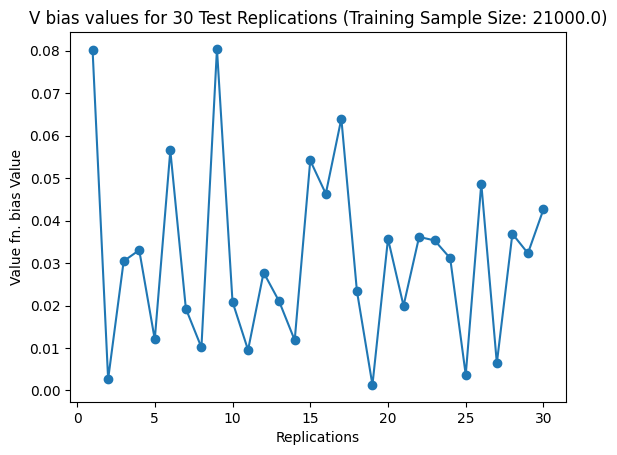

In [18]:
bias = np.abs( np.array(V_replications["V_replications_estimator"]) -   np.array(V_replications["V_replications_M1_pred"]))

num_replications = config["num_replications"]

avg_V_bias = np.mean(bias)
std_dev_bias = np.std(bias)
print(f"Average bias for the estimator: {np.mean(avg_V_bias)}")
print(f"Standard Deviation for the estimator: {std_dev_bias}\n\n")

plt.plot(range(1, num_replications + 1), bias, 'o-')
plt.xlabel(f'Replications')
plt.ylabel('Value fn. bias Value')
plt.title(f'V bias values for {num_replications} Test Replications (Training Sample Size: {training_validation_prop*config["sample_size"]})')
plt.show()



# End